<img src="./images/DLI_Header.png" width=400/>

# Fundamentals of Accelerated Data Science # 

## 08 - Introduction to cuDF Polars  ##

**Table of Contents**
<br>
This notebook briefly introduces Polars and covers the new GPU engine. This notebook covers the below sections: 
1. [Introduction to Polars](#Introduction-to-Polars)
    * [Installation](#Installation)
    * [Creating a DataFrame](#Creating-a-DataFrame)
    * [Running Basic Operations](#Running-Basic-Operations)
    * [Pandas Comparison](#Pandas-Comparison)
    * [cuDF Pandas Comparison](#cuDF-Pandas-Comparison)
2. [Basic Polars Operations](#Basic-Polars-Operations)
    * [Polars Eager Execution API Reference](#Polars-Eager-Execution-API-Reference)
    * [Exercise #1 - Load Data](#Exercise-#1---Load-Data)
    * [Exercise #2 - Calculate Average Age of Population](#Exercise-#2---Calculate-Average-Age-of-Population)
    * [Exercise #3 - Group By and Aggregation](#Exercise-#3---Group-By-and-Aggregation)
    * [Exercise #4 - Gender Distribution](#Exercise-#4---Gender-Distribution)
4. [Lazy Execution](#Lazy-Execution)
    * [Polars Lazy Execution API Reference](#Polars-Lazy-Execution-API-Reference)
    * [Execution Graph](#Execution-Graph)
    * [Exercise #5 - Creating a Lazy Dataframe](#Exercise-#5---Creating-a-Lazy-Dataframe)
    * [Exercise #6 - Query Creation](#Exercise-#6---Query-Creation)
5. [cuDF Polars](#cuDF-Polars)
    * [Accelerate Previous Code](#Accelerate-Previous-Code)
    * [Verify Results Across Engines](#Verify-Results-Across-Engines)
    * [Fallback](#Fallback)
    * [Exercise #7 - Enable GPU Engine](#Exercise-#7---Enable-GPU-Engine)

## Introduction to Polars ##
Polars is a data analysis and manipulation library that is designed for large data processing (10-100GB) on a single GPU and is known for its speed and memory efficiency. While Pandas makes use of eager execution, Polars additionally has the capability for lazy execution through the built-in query optimizer and makes use of zero-copy optimization techniques. Due to these improvements, Polars typically performs common operations 5-10x faster than Pandas, and requires 2-4 times less RAM. NVIDIA brings hardware acceleration to Polars through a new GPU engine named cuDF Polars, which is available as a pip install.

### Creating a DataFrame ###
Now let's see how the syntax looks! We will create a dataframe to use within Polars.

In [ ]:
import polars as pl
import time

start_time = time.time()

polars_df = pl.read_csv('./data/uk_pop.csv')

polars_time = time.time() - start_time

print(f"Time Taken: {polars_time:.4f} seconds")

Time Taken: 0.7877 seconds


In [2]:
polars_df.head()

shape: (5, 6)
┌─────┬─────┬────────────┬───────────┬───────────┬─────────┐
│ age ┆ sex ┆ county     ┆ lat       ┆ long      ┆ name    │
│ --- ┆ --- ┆ ---        ┆ ---       ┆ ---       ┆ ---     │
│ i64 ┆ str ┆ str        ┆ f64       ┆ f64       ┆ str     │
╞═════╪═════╪════════════╪═══════════╪═══════════╪═════════╡
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.533644 ┆ -1.524401 ┆ FRANCIS │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.426256 ┆ -1.465314 ┆ EDWARD  │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.5552   ┆ -1.496417 ┆ TEDDY   │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.547906 ┆ -1.572341 ┆ ANGUS   │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.477639 ┆ -1.605995 ┆ CHARLIE │
└─────┴─────┴────────────┴───────────┴───────────┴─────────┘

### Running Basic Operations ###
That was simple- now let's try running a few operations on the dataset! We will be loading the dataset again for a fair comparison with Pandas later.

In [3]:
start_time = time.time()

#load data
polars_df = pl.read_csv('./data/uk_pop.csv')

# Filter for ages above 0
filtered_df = polars_df.filter(pl.col('age') > 0.0)

#Sort by name
sorted_df = filtered_df.sort('name', descending=True)

print(sorted_df.head())
polars_time = time.time() - start_time
print(f"Time Taken: {polars_time:.4f} seconds")

shape: (5, 6)
┌─────┬─────┬──────────────────────────┬───────────┬───────────┬───────┐
│ age ┆ sex ┆ county                   ┆ lat       ┆ long      ┆ name  │
│ --- ┆ --- ┆ ---                      ┆ ---       ┆ ---       ┆ ---   │
│ i64 ┆ str ┆ str                      ┆ f64       ┆ f64       ┆ str   │
╞═════╪═════╪══════════════════════════╪═══════════╪═══════════╪═══════╡
│ 1   ┆ f   ┆ EAST RIDING OF YORKSHIRE ┆ 53.737344 ┆ -0.638535 ┆ ZYRAH │
│ 1   ┆ f   ┆ SHEFFIELD                ┆ 53.35529  ┆ -1.669447 ┆ ZYRAH │
│ 1   ┆ f   ┆ LINCOLNSHIRE             ┆ 53.164176 ┆ 0.015812  ┆ ZYRAH │
│ 1   ┆ f   ┆ WORCESTERSHIRE           ┆ 52.258629 ┆ -2.31696  ┆ ZYRAH │
│ 1   ┆ f   ┆ HERTFORDSHIRE            ┆ 51.731816 ┆ -0.377476 ┆ ZYRAH │
└─────┴─────┴──────────────────────────┴───────────┴───────────┴───────┘
Time Taken: 6.6244 seconds


### Pandas Comparison ###
Let's see how long this would've taken in Pandas.

In [4]:
import pandas as pd
import time
start_time = time.time()
pandas_df = pd.read_csv('./data/uk_pop.csv')

filtered_df = pandas_df[pandas_df['age'] > 0.0]

sorted_df = filtered_df.sort_values(by=['name'], ascending=False)

pandas_time = time.time() - start_time
print(f"Time Taken: {pandas_time:.4f} seconds\n")

Time Taken: 146.9642 seconds



### cuDF Pandas Comparison ###
Wow! That took quite some time to execute. Let's see if we can run it faster with cuDF Pandas.

In [5]:
# Activate cuDF Pandas
%load_ext cudf.pandas
import pandas as pd

In [6]:
import pandas as pd
import time
start_time = time.time()
pandas_df = pd.read_csv('./data/uk_pop.csv')

filtered_df = pandas_df[pandas_df['age'] > 0.0]

sorted_df = filtered_df.sort_values(by=['name'], ascending=False)

pandas_time = time.time() - start_time
print(f"Time Taken for cuDF Pandas: {pandas_time:.4f} seconds\n")

Time Taken for cuDF Pandas: 4.8869 seconds



Even with cuDF Pandas, we can see that performance is significantly slower than Polars.

## Basic Polars Operations ##
Please refer to the following API reference guide to complete the exercises below.

1. Load data
2. Calculate average age of population
3. Group By and Aggregation
4. Gender Distribution

### Polars Eager Execution API Reference ###

**DataFrame**

The main data structure for eager execution in Polars.

- `pl.DataFrame(data)`: Create a DataFrame from data
- `pl.read_csv(file)`: Read CSV file into DataFrame
- `pl.read_parquet(file)`: Read Parquet file into DataFrame

**Key Methods**

- `filter(mask)`: Filter rows based on a boolean mask
- `select(columns)`: Select specific columns
- `with_columns(expressions)`: Add or modify columns
- `group_by(columns)`: Group by specified columns
- `agg(aggregations)`: Perform aggregations on grouped data
- `sort(columns)`: Sort the data by specified columns
- `join(other, on)`: Join with another DataFrame

**Expressions**

Used to define operations on columns:

- `pl.col("column")`: Reference a column
- `pl.lit(value)`: Create a literal value
- `pl.when(predicate).then(value).otherwise(other)`: Conditional expression

**Series Operations**

- `series.sum()`: Calculate sum of series
- `series.mean()`: Calculate mean of series
- `series.max()`: Find maximum value in series
- `series.min()`: Find minimum value in series
- `series.sort()`: Sort series values

**Data Types**

- `pl.Int64`: 64-bit integer
- `pl.Float64`: 64-bit float
- `pl.Utf8`: String
- `pl.Boolean`: Boolean
- `pl.Date`: Date

**Utilities**

- `pl.concat([df1, df2])`: Concatenate DataFrames
- `df.describe()`: Generate summary statistics
- `df.to_csv(file)`: Write DataFrame to CSV
- `df.to_parquet(file)`: Write DataFrame to Parquet

The eager API executes operations immediately, providing direct access to results. It's suitable for interactive data exploration and smaller datasets.

### Exercise #1 - Load Data ###
Load the csv file into a Dataframe using Polars.

In [7]:
df = pl.read_csv('./data/uk_pop.csv')

print(df.head())

shape: (5, 6)
┌─────┬─────┬────────────┬───────────┬───────────┬─────────┐
│ age ┆ sex ┆ county     ┆ lat       ┆ long      ┆ name    │
│ --- ┆ --- ┆ ---        ┆ ---       ┆ ---       ┆ ---     │
│ i64 ┆ str ┆ str        ┆ f64       ┆ f64       ┆ str     │
╞═════╪═════╪════════════╪═══════════╪═══════════╪═════════╡
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.533644 ┆ -1.524401 ┆ FRANCIS │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.426256 ┆ -1.465314 ┆ EDWARD  │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.5552   ┆ -1.496417 ┆ TEDDY   │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.547906 ┆ -1.572341 ┆ ANGUS   │
│ 0   ┆ m   ┆ DARLINGTON ┆ 54.477639 ┆ -1.605995 ┆ CHARLIE │
└─────┴─────┴────────────┴───────────┴───────────┴─────────┘


### Exercise #2 - Calculate Average Age of Population ###
Now, filter for individuals aged 65 and above, and sort by ascending age.

In [8]:
filtered = (
    df.filter(pl.col("age") >= 65)
    .sort("age", descending=False)
)

print(filtered)

shape: (10_700_007, 6)
┌─────┬─────┬────────────┬───────────┬───────────┬──────────┐
│ age ┆ sex ┆ county     ┆ lat       ┆ long      ┆ name     │
│ --- ┆ --- ┆ ---        ┆ ---       ┆ ---       ┆ ---      │
│ i64 ┆ str ┆ str        ┆ f64       ┆ f64       ┆ str      │
╞═════╪═════╪════════════╪═══════════╪═══════════╪══════════╡
│ 65  ┆ m   ┆ DARLINGTON ┆ 54.46995  ┆ -1.507228 ┆ HAARIS   │
│ 65  ┆ m   ┆ DARLINGTON ┆ 54.480109 ┆ -1.653826 ┆ GABRIEL  │
│ 65  ┆ m   ┆ DARLINGTON ┆ 54.570427 ┆ -1.543452 ┆ THOMAS   │
│ 65  ┆ m   ┆ DARLINGTON ┆ 54.603858 ┆ -1.52194  ┆ JAYDEN   │
│ 65  ┆ m   ┆ DARLINGTON ┆ 54.557468 ┆ -1.627709 ┆ DANIEL   │
│ …   ┆ …   ┆ …          ┆ …         ┆ …         ┆ …        │
│ 90  ┆ f   ┆ NEWPORT    ┆ 51.626744 ┆ -2.859381 ┆ FREYA    │
│ 90  ┆ f   ┆ NEWPORT    ┆ 51.546043 ┆ -2.897815 ┆ GEORGINA │
│ 90  ┆ f   ┆ NEWPORT    ┆ 51.605268 ┆ -2.849656 ┆ REBECCA  │
│ 90  ┆ f   ┆ NEWPORT    ┆ 51.554649 ┆ -2.934364 ┆ JESSICA  │
│ 90  ┆ f   ┆ NEWPORT    ┆ 51.578787 ┆ -2.82795

### Exercise #3 - Group By and Aggregation ###
Next, group by county and calculate the total population and average age.

In [9]:
agg = (
    df.group_by("county")
    .agg([
        pl.len().alias("population"),
        pl.mean("age").alias("average_age")
    ])
    .sort("population", descending=True)
)

print(agg.head())

shape: (5, 3)
┌────────────┬────────────┬─────────────┐
│ county     ┆ population ┆ average_age │
│ ---        ┆ ---        ┆ ---         │
│ str        ┆ u32        ┆ f64         │
╞════════════╪════════════╪═════════════╡
│ KENT       ┆ 1568623    ┆ 41.094119   │
│ ESSEX      ┆ 1477764    ┆ 41.561557   │
│ HAMPSHIRE  ┆ 1376316    ┆ 42.416859   │
│ LANCASHIRE ┆ 1210053    ┆ 41.476016   │
│ SURREY     ┆ 1189934    ┆ 40.823224   │
└────────────┴────────────┴─────────────┘


### Exercise #4 - Gender Distribution ###
Lastly, let's calculate the percentage of males to females in the sample data.

In [10]:
gender = (
    df.group_by("sex")
    .agg(pl.len().alias("count"))
    .with_columns(
        (pl.col("count") / df.shape[0] * 100).alias("percentage")
    )
)

print(gender)

shape: (2, 3)
┌─────┬──────────┬────────────┐
│ sex ┆ count    ┆ percentage │
│ --- ┆ ---      ┆ ---        │
│ str ┆ u32      ┆ f64        │
╞═════╪══════════╪════════════╡
│ m   ┆ 28900781 ┆ 49.42003   │
│ f   ┆ 29579113 ┆ 50.57997   │
└─────┴──────────┴────────────┘


## Lazy Execution ##
Polars utilizes a technique called lazy execution to perform operations. Unlike eager execution, where operations are performed immediately, Polars defines and stores operations in a computational graph that isn't executed until explicitly required. This allows Polars to optimize the sequence of operations to minimize computation overhead and apply optimization techniques such as: applying filters early (predicate pushdown), selecting only necessary columns (projection pushdown), and executing operations in parallel. To make use of lazy execution in polars, a "LazyFrame" data structure is used.

Now, lets run the same operations with lazy execution and visualize the graph!

### Polars Lazy Execution API Reference ###

**LazyFrame**

The main entry point for lazy execution in Polars. Created from a DataFrame or data source.

- `pl.LazyFrame(data)`: Create a LazyFrame from data.
- `df.lazy()`: Convert a DataFrame to LazyFrame.

**Key Methods**

- `filter(predicate)`: Filter rows based on a condition.
- `select(columns)`: Select specific columns.
- `with_columns(expressions)`: Add or modify columns.
- `group_by(columns)`: Group by specified columns.
- `agg(aggregations)`: Perform aggregations on grouped data.
- `sort(columns)`: Sort the data by specified columns.
- `join(other, on)`: Join with another LazyFrame.
- `collect()`: Execute the lazy query and return a DataFrame.

**Expressions**

Used to define operations on columns:

- `pl.col("column")`: Reference a column.
- `pl.lit(value)`: Create a literal value.
- `pl.when(predicate).then(value).otherwise(other)`: Define a conditional expression.

**Execution**

- `collect()`: Execute and return a DataFrame.
- `fetch(n)`: Execute and return the first n rows.
- `describe_plan()`: Show the query plan for optimization insights.
- `explain()`: Explain the query execution process.

**Optimization**

- `cache()`: Cache intermediate results for faster access.
- `optimize()`: Apply query optimizations to improve performance.

The lazy API allows building complex queries that are optimized before execution, enabling better performance for large datasets.

In [11]:
import polars as pl
import time

start_time = time.time()

# Create a lazy DataFrame
lazy_df = pl.scan_csv('./data/uk_pop.csv')

# Define the lazy operations
lazy_result = (
    lazy_df
    .filter(pl.col('age') > 0.0)
    .sort('name', descending=True)
)

# Execute the lazy query and collect the results
result = lazy_result.collect()

print(result.head())
polars_time = time.time() - start_time
print(f"Time Taken: {polars_time:.4f} seconds")

shape: (5, 6)
┌─────┬─────┬──────────────────────────┬───────────┬───────────┬───────┐
│ age ┆ sex ┆ county                   ┆ lat       ┆ long      ┆ name  │
│ --- ┆ --- ┆ ---                      ┆ ---       ┆ ---       ┆ ---   │
│ i64 ┆ str ┆ str                      ┆ f64       ┆ f64       ┆ str   │
╞═════╪═════╪══════════════════════════╪═══════════╪═══════════╪═══════╡
│ 1   ┆ f   ┆ EAST RIDING OF YORKSHIRE ┆ 53.737344 ┆ -0.638535 ┆ ZYRAH │
│ 1   ┆ f   ┆ SHEFFIELD                ┆ 53.35529  ┆ -1.669447 ┆ ZYRAH │
│ 1   ┆ f   ┆ LINCOLNSHIRE             ┆ 53.164176 ┆ 0.015812  ┆ ZYRAH │
│ 1   ┆ f   ┆ WORCESTERSHIRE           ┆ 52.258629 ┆ -2.31696  ┆ ZYRAH │
│ 1   ┆ f   ┆ HERTFORDSHIRE            ┆ 51.731816 ┆ -0.377476 ┆ ZYRAH │
└─────┴─────┴──────────────────────────┴───────────┴───────────┴───────┘
Time Taken: 6.6626 seconds


### Execution Graph ###

Let's see how the unoptimized execution graph looks.

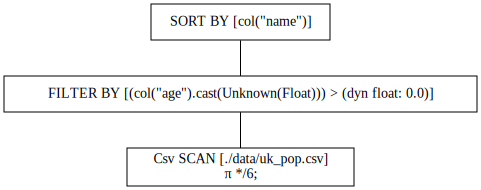

In [12]:
# Show unoptimized Graph
lazy_result.show_graph(optimized=False)

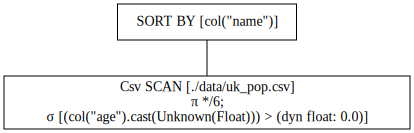

In [13]:
# Show optimized Graph
lazy_result.show_graph(optimized=True)

As we can see, during execution, Polars ran the age filter in parallel with reading the csv to save time! These type of optimizations is part of the reason why Polars is such a powerful Data Science tool.

### Exercise #5 - Creating a Lazy Dataframe ###
First, let's load the csv as a lazy dataframe.

In [14]:
lazy_df = pl.scan_csv('./data/uk_pop.csv')

### Exercise #6 - Query Creation ###
Now, let's create a query to find the 5 most common names for individuals under 30. 

In [15]:
result = (
    lazy_df.filter(pl.col("age") < 30)
    .group_by("name")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .limit(5)
    .select(["name", "count"])
)

top_5_names=result.collect()
print(top_5_names)

shape: (5, 2)
┌────────┬────────┐
│ name   ┆ count  │
│ ---    ┆ ---    │
│ str    ┆ u32    │
╞════════╪════════╡
│ OLIVER ┆ 218505 │
│ GEORGE ┆ 174261 │
│ HARRY  ┆ 173862 │
│ OLIVIA ┆ 171424 │
│ AMELIA ┆ 163302 │
└────────┴────────┘


## cuDF Polars ##
cuDF Polars is built directly into the Polars Lazy API. The only requirement is to pass engine="gpu" to the collect operation. Polars also allows defining an instance of the GPU engine for greater customization!

In [16]:
lazy_df = pl.scan_csv('./data/uk_pop.csv').collect(engine="gpu")

Now let's try defining our own engine object!

In [17]:
import polars as pl
import time

gpu_engine = pl.GPUEngine(
    device=0, # This is the default
    raise_on_fail=True, # Fail loudly if we can't run on the GPU.
)

In [18]:
lazy_df = pl.scan_csv('./data/uk_pop.csv').collect(engine=gpu_engine)

Now that the GPU is warmed up, let's try accelerating the same code as before! Notice that we added an engine parameter to the collect call.

### Accelerate Previous Code ###

In [19]:
start_time = time.time()

# Create a lazy DataFrame
lazy_df = pl.scan_csv('./data/uk_pop.csv')

# Define the lazy operations
lazy_result = (
    lazy_df
    .filter(pl.col('age') > 0.0)
    .sort('name', descending=True)
)

# Switch to gpu_engine
result = lazy_result.collect(engine=gpu_engine)

print(result.head())
polars_time = time.time() - start_time
print(f"Time Taken: {polars_time:.4f} seconds")

shape: (5, 6)
┌─────┬─────┬──────────────────────────┬───────────┬───────────┬───────┐
│ age ┆ sex ┆ county                   ┆ lat       ┆ long      ┆ name  │
│ --- ┆ --- ┆ ---                      ┆ ---       ┆ ---       ┆ ---   │
│ i64 ┆ str ┆ str                      ┆ f64       ┆ f64       ┆ str   │
╞═════╪═════╪══════════════════════════╪═══════════╪═══════════╪═══════╡
│ 1   ┆ f   ┆ EAST RIDING OF YORKSHIRE ┆ 53.737344 ┆ -0.638535 ┆ ZYRAH │
│ 1   ┆ f   ┆ SHEFFIELD                ┆ 53.35529  ┆ -1.669447 ┆ ZYRAH │
│ 1   ┆ f   ┆ LINCOLNSHIRE             ┆ 53.164176 ┆ 0.015812  ┆ ZYRAH │
│ 1   ┆ f   ┆ WORCESTERSHIRE           ┆ 52.258629 ┆ -2.31696  ┆ ZYRAH │
│ 1   ┆ f   ┆ HERTFORDSHIRE            ┆ 51.731816 ┆ -0.377476 ┆ ZYRAH │
└─────┴─────┴──────────────────────────┴───────────┴───────────┴───────┘
Time Taken: 5.5403 seconds


### Verify Results Across Engines ###
How do we know the results are the same with both the CPU and GPU engine? Luckily with Polars, we can execute the same query across both and compare results using the built in testing module! 

In [20]:
from polars.testing import assert_frame_equal

# Run on the CPU
result_cpu = lazy_result.collect()

# Run on the GPU
result_gpu = lazy_result.collect(engine="gpu")

# assert both result are equal - Will error if not equal, return None otherwise
if (assert_frame_equal(result_gpu, result_cpu) == None):
    print("The test frames are equal")

The test frames are equal


### Fallback ###
What happens when an operation isn't supported? 

In [21]:
result = (
    lazy_df
    .with_columns(pl.col('age').rolling_mean(window_size=7).alias('age_rolling_mean'))
    .filter(pl.col('age') > 0.0)  
    .collect(engine=gpu_engine)
)
print(result[::7])

ComputeError: 'cuda' conversion failed: NotImplementedError: ('Query execution with GPU not possible: unsupported operations.\nThe errors were:\n- NotImplementedError: rolling mean', [NotImplementedError('rolling mean')])

We intially constructed the GPU engine with raise_on_fail=True to ensure all operations ran on GPU. But as we can see, the rolling mean operation is not currently supported, which results in the query not executing. To enable fallback, we can simply change the raise_on_fail parameter to False.

In [22]:
gpu_engine_with_fallback = pl.GPUEngine(
    device=0, # This is the default
    raise_on_fail=False, # Fallback to CPU if we can't run on the GPU (this is the default)
)

Now let's try this query again.

In [23]:
result = (
    lazy_df
    .with_columns(pl.col('age').rolling_mean(window_size=7).alias('age_rolling_mean'))
    .filter(pl.col('age') > 0.0)  
    .collect(engine=gpu_engine_with_fallback)
)
print(result[::7])

shape: (8_259_508, 7)
┌─────┬─────┬────────────┬───────────┬───────────┬───────────┬──────────────────┐
│ age ┆ sex ┆ county     ┆ lat       ┆ long      ┆ name      ┆ age_rolling_mean │
│ --- ┆ --- ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---              │
│ i64 ┆ str ┆ str        ┆ f64       ┆ f64       ┆ str       ┆ f64              │
╞═════╪═════╪════════════╪═══════════╪═══════════╪═══════════╪══════════════════╡
│ 1   ┆ m   ┆ DARLINGTON ┆ 54.580675 ┆ -1.51359  ┆ PHILIP    ┆ 0.142857         │
│ 1   ┆ m   ┆ DARLINGTON ┆ 54.589555 ┆ -1.533749 ┆ SCOTT     ┆ 1.0              │
│ 1   ┆ m   ┆ DARLINGTON ┆ 54.526772 ┆ -1.557881 ┆ ISAAC     ┆ 1.0              │
│ 1   ┆ m   ┆ DARLINGTON ┆ 54.617086 ┆ -1.557996 ┆ SEBASTIAN ┆ 1.0              │
│ 1   ┆ m   ┆ DARLINGTON ┆ 54.551081 ┆ -1.50386  ┆ FINN      ┆ 1.0              │
│ …   ┆ …   ┆ …          ┆ …         ┆ …         ┆ …         ┆ …                │
│ 90  ┆ f   ┆ NEWPORT    ┆ 51.589194 ┆ -2.825451 ┆ FREYA     ┆ 90.0         

### Exercise #7 - Enable GPU Engine ###
The below code calculates the average latitude and longitude for each county. Let's try enabling the GPU Engine for this query!

In [24]:
# Create the lazy query with column pruning
lazy_query = (
    lazy_df
    .select(["county", "lat", "long"])  # Column pruning: select only necessary columns
    .group_by("county")
    .agg([
        pl.col("lat").mean().alias("avg_latitude"),
        pl.col("long").mean().alias("avg_longitude")
    ])
    .sort("county")
)

# Execute the query
result = lazy_query.collect(engine="gpu")

print("\nAverage latitude and longitude for each county:")
print(result.head())  # Display first few rows


Average latitude and longitude for each county:
shape: (5, 3)
┌──────────────────────────────┬──────────────┬───────────────┐
│ county                       ┆ avg_latitude ┆ avg_longitude │
│ ---                          ┆ ---          ┆ ---           │
│ str                          ┆ f64          ┆ f64           │
╞══════════════════════════════╪══════════════╪═══════════════╡
│ BARKING AND DAGENHAM         ┆ 51.545519    ┆ 0.129584      │
│ BARNET                       ┆ 51.611103    ┆ -0.218213     │
│ BARNSLEY                     ┆ 53.525843    ┆ -1.548724     │
│ BATH AND NORTH EAST SOMERSET ┆ 51.356129    ┆ -2.486656     │
│ BEDFORD                      ┆ 52.196341    ┆ -0.454976     │
└──────────────────────────────┴──────────────┴───────────────┘


In [25]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

**Well Done!**

<img src="./images/DLI_Header.png" width=400/>